<a href="https://colab.research.google.com/github/brandonso994/AttnLSTMMusicGeneration/blob/main/Train_Model_v5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras_self_attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=aa4b61fcaa14676fcaad652b8e4565cd133d0e06d139e3a7c635d081ee1d45c7
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [ ]:
from music21 import converter, instrument, note, chord, stream, volume
from fractions import Fraction
import matplotlib.pyplot as plt
import glob
import numpy as np
import nltk
import pandas as pd
import pickle
from keras.models import Sequential, Model
from keras.layers import LSTM, Dropout, Dense, Activation, Bidirectional, BatchNormalization, Input, Embedding, Concatenate, Flatten
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import CategoricalAccuracy
import tensorflow as tf
from keras import backend as K
from keras_self_attention import SeqSelfAttention

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Class function to stop training of loss goes below 0.2 to prevent overtraining
class EarlyStopOnLossCallback(EarlyStopping):
    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')
        if current_loss is not None and current_loss < 0.4:
            self.stopped_epoch = epoch
            self.model.stop_training = True
            print("Training stopped. Loss below threshold.")

In [ ]:
# Function to flatten array into 1d array
def flatten(array):
  new_array = [item for array in array for item in array]
  return new_array

# Create window sequences to feed into model for training
def sequence(notes, note_set_len, sequence_length):

  # Create Note Set
  note_values = sorted(set(note for note in notes))

  # Dictionary to encode each feature to an integer
  note_encode = dict((note, num) for num, note in enumerate(note_values))

  network_input_note = []
  note_output = []

  # Create moving window sequences, with target output being i + sequence length index
  for i in range (len(notes) - sequence_length):
    note_sequence = notes[i:i + sequence_length]
    note_input_sequence = [note_encode[note] for note in note_sequence]

    network_input_note.append(note_input_sequence)
    note_output.append(note_encode[notes[i + sequence_length]])


  # Reshape input suitable for LSTM input
  n_patterns = len(network_input_note)
  network_input_note = np.array(network_input_note)
  network_input_note = np.reshape(network_input_note, (network_input_note.shape[0], network_input_note.shape[1], 1))

  note_output = np.array(note_output)
  note_output = np.reshape(note_output, (note_output.shape[0], 1))

  return network_input_note, note_output

#Create the model
def create_model(note_set_len):

    model = Sequential()

    # Note input
    model.add(Input(shape=(None,)))
    model.add(Embedding(note_set_len, 660))
    model.add(Bidirectional(LSTM(1024, return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(Dropout(0.3))
    model.add(LSTM(1024, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(1024, return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(note_set_len, activation='softmax', name='note'))

    return model

# Train the Model. Be sure to change all paths to the folder locations you will be using
def train_model(notes, version_num):

  # Window Size Hyperparameter
  sequence_length = 60

  # Flatten arrays
  flatten_notes = flatten(notes)

  # Feature Vocabulary Size
  note_set_len = len(set(flatten_notes))

  # Create sequence windows and output variable to feed into model
  note_input, note_output = sequence(flatten_notes, note_set_len, sequence_length)

  # Initialize Model
  model = create_model(note_set_len)

  # Compile using Categorical Crossentropy and Categorical Accuracy as metrics, optmizer Adam
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

  # Early stop when accuracy drops below 0.2 loss. Model saves weights with the greatest pitch categorical accuracy.
  callbacks = [
        EarlyStopping(monitor='sparse_categorical_accuracy', patience=10, mode='max', verbose=1),
        ModelCheckpoint('/content/drive/My Drive/MRP/Model/model_weights_' + version_num + '_checkpoints.h5', monitor='sparse_categorical_accuracy', save_freq="epoch", save_best_only=True, mode='max', save_weights_only = True)
  ]

  # Fit model, 100 epochs, batch size 64
  history = model.fit(note_input, note_output,
    epochs=100, batch_size=64, callbacks=callbacks)

  # Save Stats
  model.save_weights('/content/drive/My Drive/MRP/Model/model_weights_' + version_num + '.h5')
  model.save('/content/drive/My Drive/MRP/Model/model_' + version_num + '.h5')

  with open('/content/drive/My Drive/MRP/Model/history_ ' + version_num + '.pkl','wb') as f:
    pickle.dump(history.history, f)

  with open('history_'+version_num + '.pkl','wb') as f:
    pickle.dump(history.history, f)

  return history, model

In [ ]:
# Load Pickle Files
with open('simple_notes_offsets.pkl', 'rb') as f:
  notes = pickle.load(f)

# Check Pickle Contents
note_set_len = len(set(flatten(notes)))

print(len(notes))
print(len(flatten(notes)))
print(note_set_len)

170
204458
10755


In [ ]:
history, model = train_model(notes, 'v5_3')

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/100
3194/3194 [==============================] - 193s 57ms/step - loss: 7.4517 - sparse_categorical_accuracy: 0.0169
Epoch 2/100
3194/3194 [==============================] - 109s 34ms/step - loss: 7.5011 - sparse_categorical_accuracy: 0.0171
Epoch 3/100
3194/3194 [==============================] - 102s 32ms/step - loss: 7.5582 - sparse_categorical_accuracy: 0.0160
Epoch 4/100
3194/3194 [==============================] - 103s 32ms/step - loss: 7.3997 - sparse_categorical_accuracy: 0.0174
Epoch 5/100
3194/3194 [==============================] - 99s 31ms/step - loss: 7.3578 - sparse_categorical_accuracy: 0.0172
Epoch 6/100
3194/3194 [==============================] - 101s 32ms/step - loss: 7.2710 - sparse_categorical_accuracy: 0.0175
Epoch 7/100
3194/3194 [==============================] - 103s 32ms/step - loss: 6.9684 - sparse_categorical_accuracy: 0.0205
Epoch 8/100
3194/3194 [==============================] - 102s 32ms/step - loss: 6.6831 - sparse_categorical_accuracy: 0.0244
E

In [ ]:
print(model.summary())
print(history.history.keys())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 600)         6453000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 2048)       13312000  
 l)                                                              
                                                                 
 seq_self_attention (SeqSelf  (None, None, 2048)       131137    
 Attention)                                                      
                                                                 
 dropout (Dropout)           (None, None, 2048)        0         
                                                                 
 lstm_1 (LSTM)               (None, None, 1024)        12587008  
                                                                 
 dropout_1 (Dropout)         (None, None, 1024)        0

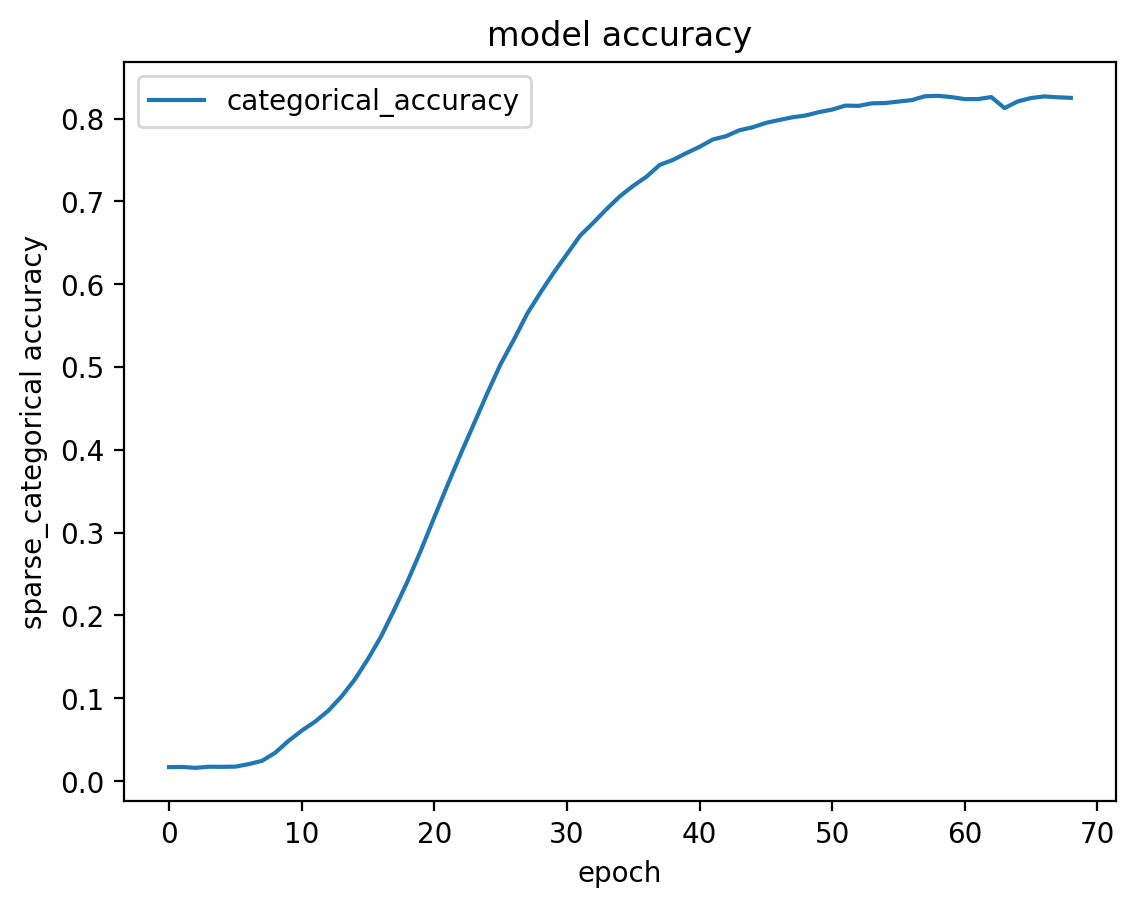

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('sparse_categorical accuracy')
plt.xlabel('epoch')
plt.legend(['categorical_accuracy'], loc='upper left')
plt.show()

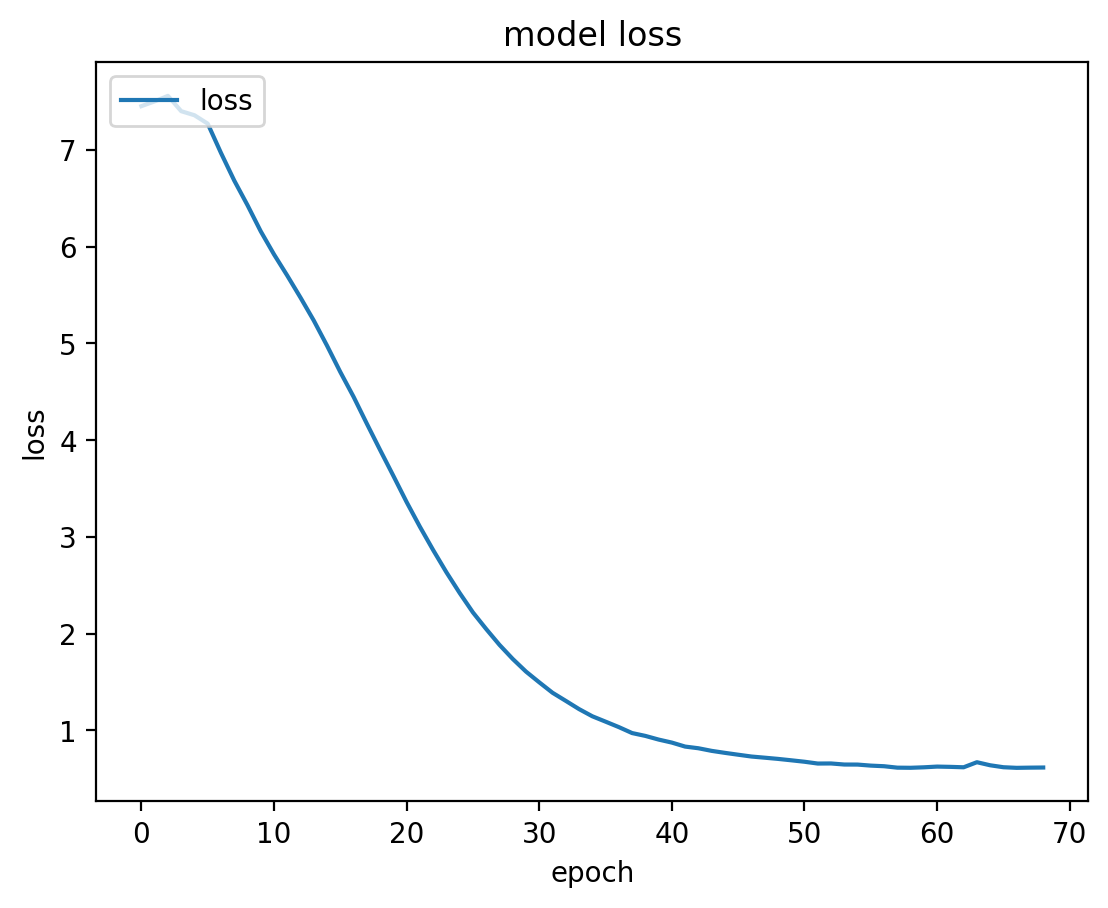

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()